In [1]:
# trick from https://stackoverflow.com/questions/73849624/getting-error-while-submitting-notebook-on-kaggle-even-after-importing-nltk-libr
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import re 
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
nltk.download('punkt')
stopwords_en = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 0

Preprocesamiento. Se retiran las columas `Unnamed: 0` y `label`.

In [3]:
df = pd.read_csv('/kaggle/input/data-p4/spam_ham_dataset.csv')
df = df.drop(['Unnamed: 0', 'label'], axis=1)

texto  = df["text"]
labels = df["label_num"]
spam   = df[df["label_num"] == 1]["text"]
ham    = df[df["label_num"] == 0]["text"]

# 1
Crear una función de Python llamada _”preprocess text”_ que reciba una
cadena de texto, a la cual aplique:

1. Tokenización
2. Lower case
3. Eliminar caracteres especiales y numeros
4. Eliminar stop words
5. Quitar cadenas vacias
6. Aplicar lematización

In [4]:
def preprocess_text(text):
    """
    Método para preprocesamiento. 
    Aplica las siguientes transformaciones:
    1. Tokenización
    2. Lower case
    3. Eliminar caracteres especiales y numeros
    4. Eliminar stop words
    5. Quitar cadenas vacias
    6. Lematización
    
    Args:
    -----
    - text el texto a procesar.
    
    Returns:
    --------
    El texto preprocesado.
    """
    wnl    = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [re.sub("[^A-Za-z]", "", word) for word in tokens]
    tokens = list(filter(None, tokens))
    tokens = [word for word in tokens if word not in stopwords_en]
    tokens = [wnl.lemmatize(word) for word in tokens]
    return tokens

In [5]:
email_text = "Congratulations! You've won a free trip to Hawaii. Click here to claim your prize!"
print(email_text)
# Preprocesamiento del texto del correo electrónico
preprocessed_email = preprocess_text(email_text)
print("Texto preprocesado:", preprocessed_email)

Congratulations! You've won a free trip to Hawaii. Click here to claim your prize!
Texto preprocesado: ['congratulation', 'free', 'trip', 'hawaii', 'click', 'claim', 'prize']


# 2 
Implementación del clasificador spam/ham utilizando bayes ingenuo.

In [6]:
def process(data):
    """
    Función para procesar los datos aplicando una 
    transformación. En esta caso en particular, 
    `preprocess_text` que realiza las transformaciones
    descritas en 1.
    
    Args:
    -----
    - data el conjunto de datos a procesar. Debe 
    ser una Serie de pandas.
    
    Returns:
    --------
    Una Serie de pandas con el preprocesamiento aplicado.
    """
    return data.transform(preprocess_text).tolist()

def build_set(data):
    """
    Función que crea un conjunto de conjuntos para los 
    correos. Esto nos ayudará a filtrar por estos 
    palabras posteriormente.
    
    Args:
    -----
    - data: los datos a convertir en conjunto (set).
    
    Return:
    -------
    El conjunto (set) de datos únicos.
    """
    result_set = set()
    for elem in data:
        result_set.update(set(elem))
    return result_set

def build_lang_dict(data, data_proc, set_data):
    """
    Función para obtener la probabilidad de que aparezca una 
    palabra dado que es esta en el conjunto `data`. Iteramos
    sobre las palabras que aparecen en `data` y 
    posteriormente comparamos con los elementos internos de 
    data_proc.
    
    Args:
    ----- 
    - data los datos originales.
    - data_proc el conjunto procesado. 
    - set_data el conjunto (set) de datos.
    
    Return:
    -------
    Diccionario con las probabilidades de las 
    palabras únicas en los datos.
    """
    result_dict = {}
    total_elems = len(data)
    for elem in set_data:
        pInData = 0
        for inner_elem in data_proc:
            if elem in inner_elem:
                pInData += 1
            if pInData == 0: 
                proba = 1 / total_elems
            else:
                proba = pInData / total_elems
            result_dict[elem] = proba
    return result_dict

In [7]:
# Preprocesado de conjuntos para el modelo.
texto_proc = process(texto)
spam_proc  = process(spam)
ham_proc   = process(ham)

# Creación de conjuntos para 'spam' y 'ham'
set_spam = build_set(spam_proc)
set_ham  = build_set(ham_proc)

# Creación de diccionarios de probabilidades
dict_spamicity = build_lang_dict(spam, spam_proc, set_spam)
dict_ham       = build_lang_dict(ham, ham_proc, set_ham)

In [8]:
# Probabilidades totales de los conjuntos
total_spam = len(spam)
total_ham  = len(ham)
S = total_spam/(total_spam+total_ham)
H = total_ham/(total_spam+total_ham)
print(S, H)

0.2898859021465867 0.7101140978534133


In [9]:
#Preparamos test individuales
tests  = ["""Subject: re : indian springs
this deal is to book the teco pvr revenue . it is my understanding that teco
just sends us a check , i haven ' t received an answer as to whether there is a
predermined price associated with this deal or if teco just lets us know what
we are giving . i can continue to chase this deal down if you need .""", """Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin"""]
tests = [preprocess_text(txt) for txt in tests]

In [10]:
# Quitamos de los emails las palabras que no encontramos
texto_preprocesado = []
for email in tests:
  email_nuevo = []
  for palabra in email:
    if palabra in set_ham:
      email_nuevo.append(palabra)
    else:
      if palabra in set_spam:
        email_nuevo.append(palabra)
  texto_preprocesado.append(email_nuevo)
texto_preprocesado

[['subject',
  'indian',
  'spring',
  'deal',
  'book',
  'teco',
  'pvr',
  'revenue',
  'understanding',
  'teco',
  'sends',
  'u',
  'check',
  'received',
  'answer',
  'whether',
  'predermined',
  'price',
  'associated',
  'deal',
  'teco',
  'let',
  'u',
  'know',
  'giving',
  'continue',
  'chase',
  'deal',
  'need'],
 ['subject',
  'photoshop',
  'window',
  'office',
  'cheap',
  'main',
  'trending',
  'abasement',
  'darer',
  'prudently',
  'fortuitous',
  'undergone',
  'lighthearted',
  'charm',
  'orinoco',
  'taster',
  'railroad',
  'affluent',
  'pornographic',
  'cuvier',
  'irvin',
  'parkhouse',
  'blameworthy',
  'chlorophyll',
  'robed',
  'diagrammatic',
  'fogarty',
  'clear',
  'bayda',
  'inconveniencing',
  'managing',
  'represented',
  'smartness',
  'hashish',
  'academy',
  'shareholder',
  'unload',
  'badness',
  'danielson',
  'pure',
  'caffein',
  'spaniard',
  'chargeable',
  'levin']]

In [11]:
# Preparamos tests para medir metricas
X_, X_test, y_, y_test = train_test_split(texto_proc, labels, test_size=0.33, random_state=42)

# Creamos funcion que reciba una lista de probabilidades, multiplique todas y regrese el resultado
def mult(probas) :        # multiplicar todas las probas
    total_prob = 1
    for proba in probas:
      total_prob*=proba
    # Multiplicar todas las probas
    return total_prob
# Creamos funcion que aplique Naive_Bayes a un email, con un threshold como parametro
def Naive_Bayes(email,threshold):
    probs = []
    S # prob_spam
    H # prob_ham
    # Iteramos sobre las palabras del email
    for palabra in email:

    # Calculamos la proba de PdadoS #*Si es 0 asignamos una probabilidad baja 1/(total_spam+2)
      try:
        PdadoS = dict_spamicity[palabra]
      except:
        PdadoS = 1/total_spam
    # Calculamos la proba de PdadoH #*Si es 0 asignamos una probabilidad baja 1/(total_spam+2)
      try:
          PdadoH = dict_ham[palabra]
      except:
          PdadoH = 1/total_ham
    # Aplicamos Bayes para obtener SdadoP
      probaB = PdadoS*S/(PdadoS*S+ PdadoH*H)
      probs.append(probaB)
    # Multiplicamos todas las probas para obtener el total de SdadoEmail
    SdadoEmail = mult(probs)
    # Aplicamos el Threshold para determinar si es o no es spam
    # print(SdadoEmail)
    if SdadoEmail >= threshold:
      SdadoEmail =1
    else:
      SdadoEmail = 0
    return SdadoEmail
for email in texto_preprocesado:
  print(Naive_Bayes(email,.00000000000001))

0
1


In [12]:
y_pred = [Naive_Bayes(email,.00000000000001) for email in X_test]
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1246
           1       0.69      0.43      0.53       461

    accuracy                           0.80      1707
   macro avg       0.76      0.68      0.70      1707
weighted avg       0.78      0.80      0.78      1707



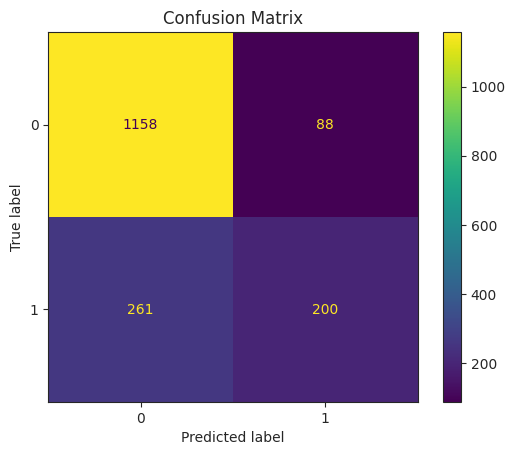

In [13]:
sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

# Comparación

El modelo de este notebook respecto al original (_2024_02_22_RPAA_Naive_Bayes_) presenta, con las adiciones sobre el preprocesamiento de los 
correos mediante la función modificada `preprocess_text`, una mejora prediciendo verdaderos positivos, pero en cambio un error más grande prediciendo 
verdaderos negativos. Esto lo podemos notar por la métrica de precisión sobre ambas clases: para la `clase 0` esta aumenta considerablemente, mientras que para la `clase 1`, decrementa; sin embargo, observamos un incremento en `recall` para esta clase, lo que implica que para la `clase 0`. Para `f1-score` vemos un incremento para ambas clases. Finalmente, para `accuracy` vemos un ligero incremento respecto a la versión original. En la siguiente tabla vemos resumida esta comparativa por métricas:

|         Clase             | precision | recall | f1-score | support |
|---------------------------|-----------|--------|----------|---------|
| Clase 0 (original)        | 0.76      | 0.98   | 0.86     | 1246    |
| Clase 1 (original)        | 0.75      | 0.18   | 0.29     | 461     |
| Clase 0 (**modificado**)  | 0.82      | 0.93   | 0.87     | 1246    |
| Clase 1 (**modificado**)  | 0.69      | 0.43   | 0.53     | 461     |
